In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Encoding
from sklearn.preprocessing import StandardScaler

# Model saving
import joblib


In [2]:
df = pd.read_csv("C:\\Users\\Faizal\\Downloads\\car data.csv")
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
# Check basic info
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64

In [4]:
# Drop irrelevant column if present
if 'Car_Name' in df.columns:
    df.drop('Car_Name', axis=1, inplace=True)

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Check unique values in categorical columns
for col in df.select_dtypes(include='object').columns:
    print(f"{col} --> {df[col].unique()}")

Fuel_Type --> ['Petrol' 'Diesel' 'CNG']
Selling_type --> ['Dealer' 'Individual']
Transmission --> ['Manual' 'Automatic']


In [ ]:
# Create 'Car_Age' column from 'Year'
df['Car_Age'] = 2025 - df['Year']
df.drop('Year', axis=1, inplace=True)

# Create 'Price_per_KM'
df['Price_per_KM'] = df['Selling_Price'] / (df['Kms_Driven'] + 1)  # Avoid divide by zero

# Log-transform skewed column
df['Kms_Driven'] = np.log(df['Kms_Driven'] + 1)

In [6]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Selling_Price,Present_Price,Driven_kms,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Selling_type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,11,False,True,False,True
1,4.75,9.54,43000,0,12,True,False,False,True
2,7.25,9.85,6900,0,8,False,True,False,True
3,2.85,4.15,5200,0,14,False,True,False,True
4,4.60,6.87,42450,0,11,True,False,False,True


In [7]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "R2 Score": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred)
    }

# Show results
pd.DataFrame(results).T

,R2 Score,MSE
Linear Regression,0.752723,6.373125
Ridge,0.753310,6.357998
Lasso,0.588224,10.612821
Random Forest,0.592487,10.502945


In [11]:
for name, model in models.items():
    score = cross_val_score(model, X_scaled, y, scoring='r2', cv=5)
    print(f"{name} - Cross Validation R2 Score: {score.mean():.4f}")

Linear Regression - Cross Validation R2 Score: -20.5064
Ridge - Cross Validation R2 Score: -20.5126
Lasso - Cross Validation R2 Score: -27.7372
Random Forest - Cross Validation R2 Score: 0.2827


In [12]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'n_estimators': 100}


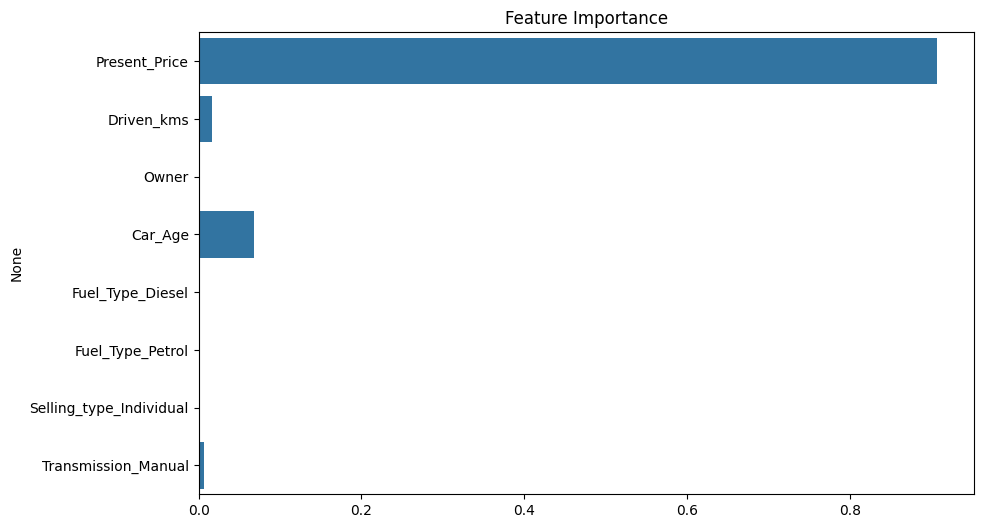

In [14]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

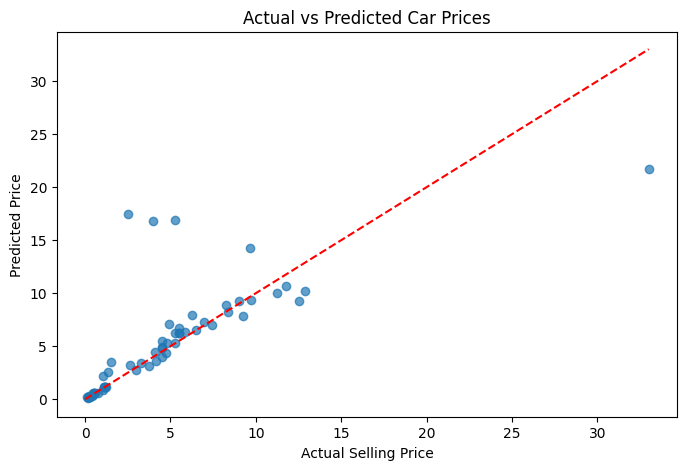

In [15]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.show()

In [16]:
joblib.dump(best_model, "best_car_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("📉 Mean Absolute Error (MAE):", round(mae, 2))
print("📉 Root Mean Squared Error (RMSE):", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))

NameError: name 'y_test' is not defined